In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from tqdm import tqdm,tqdm_notebook
import mlflow
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [22]:
writer = SummaryWriter()

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
class PairedImageDataset(Dataset):
    def __init__(self, base_folder1, base_folder2, transform=None, grayscale_transform=None):
        self.base_folder1 = base_folder1
        self.base_folder2 = base_folder2
        self.transform = transform
        self.grayscale_transform = grayscale_transform

        self.image_pairs = []
        self.class_to_idx = {}
        
        # Assuming folder structure and file names are identical across both folders
        for sub_folder in sorted(os.listdir(base_folder1)):
            class_index = len(self.class_to_idx)
            self.class_to_idx[sub_folder] = class_index
            
            sub_folder_path1 = os.path.join(base_folder1, sub_folder)
            sub_folder_path2 = os.path.join(base_folder2, sub_folder+" GT")
            
            if os.name == 'nt':
                sub_folder_path1 = sub_folder_path1.replace('\\','/')
                sub_folder_path2 = sub_folder_path2.replace('\\','/')
            
            
            if not os.path.isdir(sub_folder_path1) or not os.path.isdir(sub_folder_path2):
                print(f'path is not dir: [{sub_folder_path1}] and [{sub_folder_path2}]')
                print(os.path.exists(sub_folder_path1))
                print(os.path.exists(sub_folder_path2))
                continue
            
            for fname in sorted(os.listdir(sub_folder_path1)):
                if not fname.endswith(('.png', '.jpg', '.jpeg')):
                    continue
                path1 = os.path.join(sub_folder_path1, fname)
                path2 = os.path.join(sub_folder_path2, fname)
                
                if os.name == 'nt':
                    path1 = path1.replace('\\','/')
                    path2 = path2.replace('\\','/')
   
                
                self.image_pairs.append((path1, path2, class_index))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        path1, path2, class_index = self.image_pairs[idx]
        
        # Load images
        image1 = Image.open(path1).convert('RGB')
        image2 = Image.open(path2).convert('RGB')
        
        # Apply transformations
        if self.transform is not None:
            image1 = self.transform(image1).to(device)
        if self.grayscale_transform is not None:
            image2 = self.grayscale_transform(image2)
            # Applying additional grayscale transform
            image2 = transforms.Grayscale()(image2).to(device)
        
        class_index = torch.tensor(class_index, dtype=torch.long).to(device)
        return image1, image2, class_index

In [25]:
image_directory = 'Images'
mask_directory = 'Masks'

img_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

img_dataset = PairedImageDataset(image_directory, mask_directory, transform=img_transforms, grayscale_transform=img_transforms)

In [26]:
def visualize_img(dataset, index=None, cmap=None):
    """
    Visualizes an image and its corresponding mask from the dataset.

    Parameters:
    - dataset: The paired dataset instance.
    - index: Optional index to specify a particular dataset item to visualize.
             If None, a random item is chosen.
    - cmap: Colormap for displaying the images.
    """
    # Select a random index if none is provided
    if index is None:
        index = np.random.randint(0, len(dataset))
    
    # Fetch the image and mask using the dataset's __getitem__ method
    image, mask, _ = dataset[index]
    
    # Convert images to numpy arrays if they're PyTorch tensors
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).cpu().numpy()
    if torch.is_tensor(mask):
        mask = mask.squeeze().cpu().numpy()  # Assuming mask might have a channel dimension to be squeezed
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(image, cmap=cmap)
    axes[1].imshow(mask, cmap='gray')  # Masks are typically visualized in grayscale
    axes[0].set_title("Image")
    axes[1].set_title("Mask")
    axes[0].axis('off')
    axes[1].axis('off')
    plt.show()

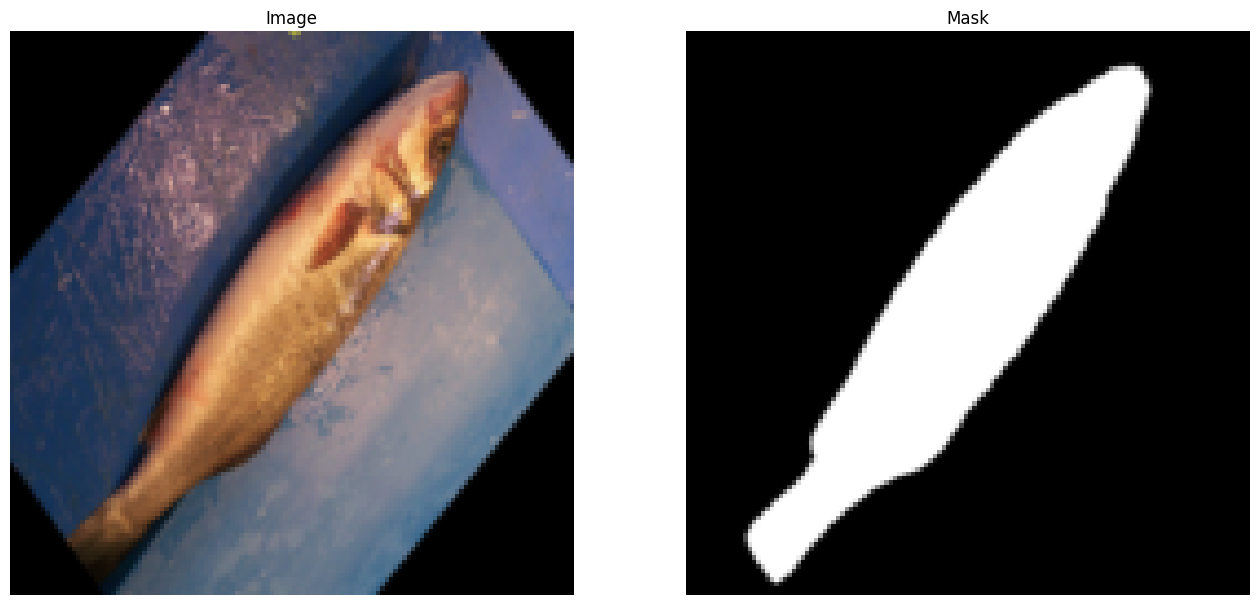

In [27]:
visualize_img(img_dataset,cmap="gray")

In [28]:
def calculate_same_padding(input_size, kernel_size, stride):
    """
    Calculate the padding needed for 'same' padding.

    Parameters:
    input_size (tuple): The height and width of the input (H, W).
    kernel_size (int or tuple): The size of the kernel (KH, KW).
    stride (int or tuple): The stride of the convolution (SH, SW).

    Returns:
    tuple: The padding (vertical, horizontal) needed for 'same' padding.
    """
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(stride, int):
        stride = (stride, stride)
    
    pad_along_height = max((input_size[0] - 1) * stride[0] + kernel_size[0] - input_size[0], 0)
    pad_along_width = max((input_size[1] - 1) * stride[1] + kernel_size[1] - input_size[1], 0)

    # Divide by 2 and round up to get equal padding on both sides
    pad_top = pad_along_height // 2
    pad_bottom = pad_along_height - pad_top
    pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left

    return (pad_left, pad_right, pad_top, pad_bottom)

In [29]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         return self.relu(x)

In [30]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)  # New convolutional layer
        x = self.bn2(x)    # Batch normalization
        return self.relu2(x)


In [31]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        conv_out = self.conv_block(x)
        pooled_out = self.pool(conv_out)
        return conv_out, pooled_out

class EncoderArm(nn.Module):
    def __init__(self, input_channels):
        super(EncoderArm, self).__init__()
        self.e0 = EncoderBlock(input_channels, 64)
        self.e1 = EncoderBlock(64, 128)
        self.e2 = EncoderBlock(128, 256)
        self.e3 = EncoderBlock(256, 512)
        self.e4 = EncoderBlock(512, 1024)

    def forward(self, x):
        s = []
        
        skip_out, pool_out = self.e0(x)
        s.append(skip_out)

        for encoder in [self.e1, self.e2, self.e3, self.e4]:
            skip_out, pool_out = encoder(pool_out)
            s.append(skip_out)

        return s, pool_out

In [32]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat([x, skip_features], dim=1)
        x = self.conv_block(x)
        return x

class DecoderArm(nn.Module):
    def __init__(self, base_channels, skip_channels_list):
        super(DecoderArm, self).__init__()
        self.d0 = DecoderBlock(base_channels, skip_channels_list[4], 1024)
        self.d1 = DecoderBlock(1024, skip_channels_list[3], 512)
        self.d2 = DecoderBlock(512, skip_channels_list[2], 256)
        self.d3 = DecoderBlock(256, skip_channels_list[1], 128)
        self.d4 = DecoderBlock(128, skip_channels_list[0], 64)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, base, skip_connection):        
        d0 = self.d0(base, skip_connection[4])
        d1 = self.d1(d0, skip_connection[3])
        d2 = self.d2(d1, skip_connection[2])
        d3 = self.d3(d2, skip_connection[1])
        d4 = self.d4(d3, skip_connection[0])
        mask_outputs = self.sigmoid(self.final_conv(d4))
        return mask_outputs

In [33]:
class FullyConnectedBlock(nn.Module):
    def __init__(self, input_features, num_classes):
        super(FullyConnectedBlock, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(input_features)
        self.dense1 = nn.Linear(input_features, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.batch_norm2 = nn.BatchNorm1d(4096)
        self.dense2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.batch_norm3 = nn.BatchNorm1d(4096)
        self.dense3 = nn.Linear(4096, num_classes)
        self.num_classes = num_classes

    def forward(self, x):        
        x = self.batch_norm1(x)
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.batch_norm3(x)
        if self.num_classes == 2:
            return torch.sigmoid(self.dense3(x))
        else:
            return F.log_softmax(self.dense3(x), dim=1)

class ClassificationTail(nn.Module):
    def __init__(self, input_features, num_classes):
        super(ClassificationTail, self).__init__()
        self.fc_block = FullyConnectedBlock(input_features, num_classes)

    def forward(self, x):
        return self.fc_block(x)

In [34]:
def jaccard_coef(y_true, y_pred):
    """
    Calculate the Jaccard coefficient between predictions and ground truth.
    
    Parameters:
    - y_true: the ground truth tensor.
    - y_pred: the predicted tensor.
    
    Both tensors should have the same shape.
    
    Returns:
    - Jaccard coefficient as a float.
    """
    # Flatten the tensors to simplify the intersection and union calculation
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    
    # Calculate the intersection and union
    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f) - intersection
    
    # Calculate the Jaccard index (IoU)
    iou = (intersection + 1.0) / (union + 1.0)
    return iou

def jaccard_coef_loss(y_true, y_pred):
    """
    Compute the Jaccard loss, which is 1 minus the Jaccard coefficient.
    
    Parameters:
    - y_true: the ground truth tensor.
    - y_pred: the predicted tensor.
    
    Both tensors should have the same shape.
    
    Returns:
    - Jaccard loss as a float.
    """
    return -jaccard_coef(y_true, y_pred)

In [35]:
class CombinedModel(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(CombinedModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

    def forward(self, x):
        skips, bottleneck = self.encoder(x)
        segmentation_output = self.decoder(bottleneck, skips)
        
        bottleneck_cpy = bottleneck.clone().view(bottleneck.shape[0],-1)
        classification_output = self.classifier(bottleneck_cpy)
        return segmentation_output, classification_output

In [36]:
# Model instantiation
encoder = EncoderArm(3)
decoder = DecoderArm(1024,[64,128,256,512,1024])
classifier = ClassificationTail(1024*4*4,len(img_dataset.class_to_idx))


model = CombinedModel(encoder, decoder, classifier).to(device)

# Loss functions
segmentation_loss_fn = jaccard_coef_loss
classification_loss_fn = nn.CrossEntropyLoss()  # or nn.BCEWithLogitsLoss for binary classification

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [37]:
img_dataset

In [38]:
img_dataset = img_dataset

train_len = int(len(img_dataset) * 0.8)
test_len = int(len(img_dataset) - train_len)

train_img_dataset,test_img_dataset = torch.utils.data.random_split(img_dataset,[train_len,test_len])

train_dataloader = DataLoader(train_img_dataset,batch_size=16)
test_dataloader = DataLoader(test_img_dataset,batch_size=16)

In [39]:
sample_input = torch.randn(1,3,128,128).to(device)
writer.add_graph(model, sample_input)

In [40]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_idx, batch in tqdm_notebook(enumerate(train_dataloader),total=len(train_img_dataset)/16):
        inputs, segmentation_targets, classification_targets = batch  # Adjust based on your dataset
        
        # Forward pass
        segmentation_output, classification_output = model(inputs)
        
        # Calculate losses
        segmentation_loss = segmentation_loss_fn(segmentation_output, segmentation_targets)
        classification_loss = classification_loss_fn(classification_output, classification_targets)
        
        # Combine losses
        loss = segmentation_loss + classification_loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss = loss.item()
        total_loss += batch_loss

        # Log loss for each batch
        writer.add_scalar('Loss/Batch', batch_loss, epoch * len(train_dataloader) + batch_idx)
        writer.add_scalar('Loss/Segmentation loss', segmentation_loss, epoch * len(train_dataloader) + batch_idx)
        writer.add_scalar('Loss/classification loss', classification_loss, epoch * len(train_dataloader) + batch_idx)
    
    # Calculate average loss for the epoch
    epoch_loss = total_loss // len(train_dataloader)
    print(f"Epoch {epoch+1}, Total Loss: {epoch_loss}")
    
    # Log loss for each epoch
    writer.add_scalar('Loss/Epoch', epoch_loss, epoch)
    
    # Log a sample from the test dataset (assuming you have a test_dataloader)
    with torch.no_grad():
        model.eval()
        test_inputs, test_segmentation_targets, _ = next(iter(test_dataloader))
        test_segmentation_output, test_classification_output = model(test_inputs)

        # Select a sample and its predictions for visualization
        test_images_grid = make_grid(test_inputs[:4], nrow=4)     
        test_segmentation_grid = make_grid(test_segmentation_targets[:4], nrow=4)  # No need to unsqueeze as it's already [batch, channel, H, W]
        predicted_segmentation_grid = make_grid(test_segmentation_output[:4], nrow=4)  # Convert predictions to single-channel masks, keeping the shape consistent

        # Log the images
        writer.add_image('Test/Sample Images', test_images_grid, epoch)
        writer.add_image('Test/True Segmentations', test_segmentation_grid, epoch)
        writer.add_image('Test/Predicted Segmentations', predicted_segmentation_grid, epoch)

        # Assuming classification targets are binary/multiclass, you can log predictions as histograms or texts
        # For demonstration, logging the predicted classes (assuming binary classification for simplicity)
        predicted_classes = torch.sigmoid(test_classification_output[:4]) > 0.5  # Threshold for binary classification
        writer.add_histogram('Test/Predicted Classes', predicted_classes.float(), epoch)

# Don't forget to close the writer when you're done
writer.close()

/tmp/ipykernel_239954/3933350191.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, batch in tqdm_notebook(enumerate(train_dataloader),total=len(train_img_dataset)/16):


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 1, Total Loss: 0.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 2, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 3, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 4, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 5, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 6, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 7, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 8, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 9, Total Loss: -1.0


  0%|          | 0/450.0 [00:00<?, ?it/s]

Epoch 10, Total Loss: -1.0
